# Detecting My Brita with SSD_Inception_v2_coco_2018_03_29


## <ins>Preparation
- I'm using GoogleColab
- Change RUNTIME to GPU

Choose TensorFlow1.x

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Create "tf1_retrain" directory inside the directory you've just created

## <ins>***Environment Setup for Object Detection API***

Git clone under, /content/gdrive/MyDrive/tf1_retrain



In [ ]:
!git clone https://github.com/tensorflow/models.git /content/gdrive/MyDrive/tf1_retrain

Cloning into '/content/gdrive/MyDrive/tf1_retrain'...
remote: Enumerating objects: 69341, done.
remote: Total 69341 (delta 0), reused 0 (delta 0), pack-reused 69341
Receiving objects: 100% (69341/69341), 577.33 MiB | 13.02 MiB/s, done.
Resolving deltas: 100% (48860/48860), done.
Checking out files: 100% (2963/2963), done.


Install requirements

In [4]:
!pip install tf_slim
!pip install lvis
!pip install --no-deps tensorflowjs==1.4.0
!pip install tensorflow.io

Set Environment

In [5]:
import os
%cd /content/gdrive/MyDrive/tf1_retrain/research
!protoc object_detection/protos/*.proto --python_out=.

pwd = os.getcwd()
os.environ['PYTHONPATH'] += f':{pwd}:{pwd}/slim'

/content/gdrive/MyDrive/tf1_retrain/research


Confirm whether environment is set

In [5]:
!python object_detection/builders/model_builder_tf1_test.py

Using TensorFlow backend.
Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model
[       OK ] ModelBuilderTF1Test.test_create_experimental_model
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_faste

## <ins>***Prepare Annotation Data***

Create Directory like below
```
/content/gdrive/MyDrive/tf1_retrain/ 
    ├── annotations
    |   └── xmls
    ├── images 
    ├── checkpoints
    ├── tf_record 
    ├── retrained_output
    ...

```

- File placement
1. Save Images under tf1_retrain/images/ (I've prepared 25 images(*1.jpg,2.jpg,...25.jpg*) of brita)
1. Save annotation Data(xml files) under tf1_retrain/annotations/xmls/ (I've annotated the data using LabelIMG)
1. Create [*label_map.pbtxt*](./label_map.pbtxt) and save it under tf1_retrain/annotations/
1. Create [*trainval.txt*](./trainval.txt) and save it under tf1_retrain/annotations/
1. Create [*xml_to_csv.py*](./xml_to_csv.py) under tf1_retrain/annotations/, and use this to convert individual xml files to a single csv file.

In [ ]:
!python3 /content/gdrive/MyDrive/tf1_retrain/annotations/xml_to_csv.py

labels.csv exported to /xmls/ directory


- Create [*create_tf_record.py*](./create_tf_record.py) under tf1_retrain/research/object_detection/dataset_tools/, and use the previously made csv file to convert input data to *tfrecords*.

In [ ]:
!python /content/gdrive/MyDrive/tf1_retrain/research/object_detection/dataset_tools/create_tf_record.py

/content/gdrive/MyDrive/tf1_retrain/research


W0228 02:56:44.376268 140541650225024 module_wrapper.py:139] From /content/gdrive/MyDrive/tf1_retrain/research/object_detection/dataset_tools/create_tf_record.py:79: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0228 02:56:44.525686 140541650225024 module_wrapper.py:139] From /content/gdrive/MyDrive/tf1_retrain/research/object_detection/dataset_tools/create_tf_record.py:38: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/gdrive/MyDrive/tf1_retrain/tf_record/train.record


- Get the model[ssd_inception_v2_coco_2018_01_28](http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz)）Save the following files under tf1_retrain/checkpoints/<br>
  - model.ckpt.meta
  - model.ckpt.index
  - model.ckpt.data-00000-of-00001

- Create [*ssd_inception_v2_coco.config*](./ssd_inception_v2_coco.config) under /content/gdrive/MyDrive/tf1_retrain<BR>
    ***NOTE***：

    ```
    model {
      ssd {
        num_classes: 1 #Only Brita
        box_coder {
          faster_rcnn_box_coder {
            y_scale: 10.0
            x_scale: 10.0
            height_scale: 5.0
            width_scale: 5.0

        ...

        fine_tune_checkpoint: "/content/gdrive/MyDrive/tf1_retrain/checkpoints/model.ckpt" #Path to Checkpoint
          from_detection_checkpoint: true
          num_steps: 100
          data_augmentation_options {
            random_horizontal_flip {
            }
          }

        ...

        train_input_reader: {
          tf_record_input_reader {
            input_path: "/content/gdrive/MyDrive/tf1_retrain/tf_record/train.record"　#Path to tfrecords
          }
          label_map_path: "/content/gdrive/MyDrive/tf1_retrain/annotations/label_map.pbtxt"　#Path to label.pbtxt
        }

        ...

        #For simplicity, I'm using the same data for training and evaluation
        eval_input_reader: {
          tf_record_input_reader {
            input_path: "/content/gdrive/MyDrive/tf1_retrain/tf_record/train.record" #Path to tfrecords
          }
          label_map_path: "/content/gdrive/MyDrive/tf1_retrain/annotations/label_map.pbtxt" #Path to label.pbtxt
          shuffle: false
          num_readers: 1
        }

        ...
    ```

## <ins>***Re-train Model***

Lower numpy version(I couldn't retrain the model when I was using the newest version)

In [6]:
!pip install numpy==1.19.0

Run Training<br>
[--train_dir]：Export Path<br>
[--pipeline_config_path]: Path to Model Pipeline Config file

In [ ]:
!python /content/gdrive/MyDrive/tf1_retrain/research/object_detection/legacy/train.py \
    --logtostderr \
    --train_dir=/content/gdrive/MyDrive/tf1_retrain/retrained_output \
    --pipeline_config_path=/content/gdrive/MyDrive/tf1_retrain/ssd_inception_v2_coco.config

Export Model

In [ ]:
!python /content/gdrive/MyDrive/tf1_retrain/research/object_detection/export_inference_graph.py \
    --input_type image_tensor\
    --pipeline_config_path /content/gdrive/MyDrive/tf1_retrain/ssd_inception_v2_coco.config \
    --trained_checkpoint_prefix  /content/gdrive/MyDrive/tf1_retrain/retrained_output/model.ckpt-100 \
    --output_directory /content/gdrive/MyDrive/tf1_retrain/retrained_output/fine_tuned_model

## <ins>***Confirm Retrained Model***

Import

In [11]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops

Change Directory and import rest<br>
※You can find "utils" when you are under /object_detection/

In [12]:
%cd object_detection/
from utils import label_map_util
from utils import visualization_utils as vis_util

/content/gdrive/MyDrive/tf1_retrain/research/object_detection


Set Parameters

In [13]:
NUM_CLASSES = 1
TEST_IMAGE_PATHS =["/content/gdrive/MyDrive/tf1_retrain/images/1.jpg", "/content/gdrive/MyDrive/tf1_retrain/images/2.jpg","/content/gdrive/MyDrive/tf1_retrain/images/3.jpg"]
PATH_TO_LABELS = "/content/gdrive/MyDrive/tf1_retrain/annotations/label_map.pbtxt"

PATH_TO_FROZEN_GRAPH = "/content/gdrive/MyDrive/tf1_retrain/retrained_output/fine_tuned_model/frozen_inference_graph.pb"
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

Load frozen_inference_graph

In [14]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

Load Labels


In [15]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

Create Function for single Image

In [16]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

Create Function to convert images to numpy arrays

In [17]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

Run Inference

In [18]:
%matplotlib inline

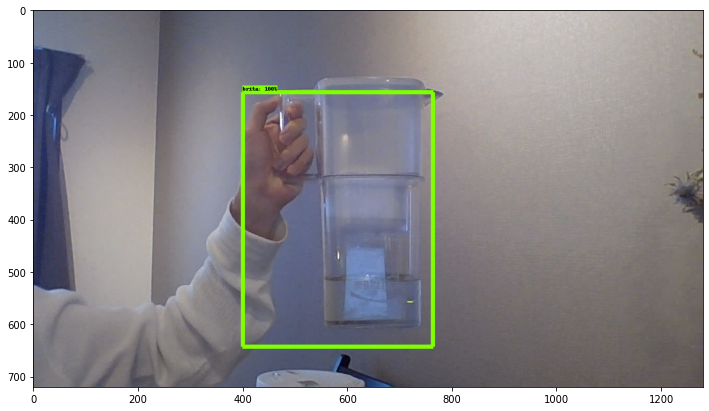

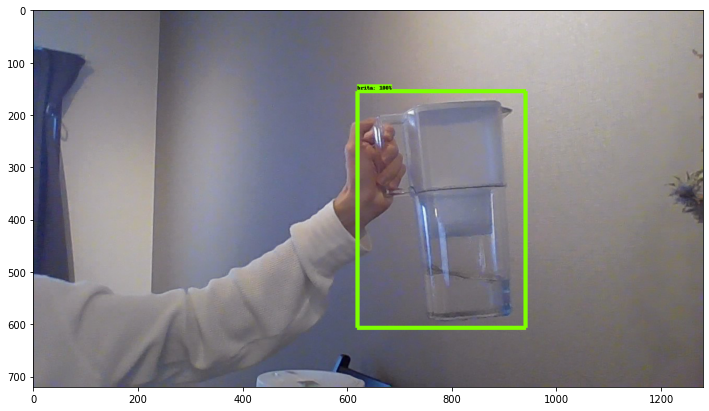

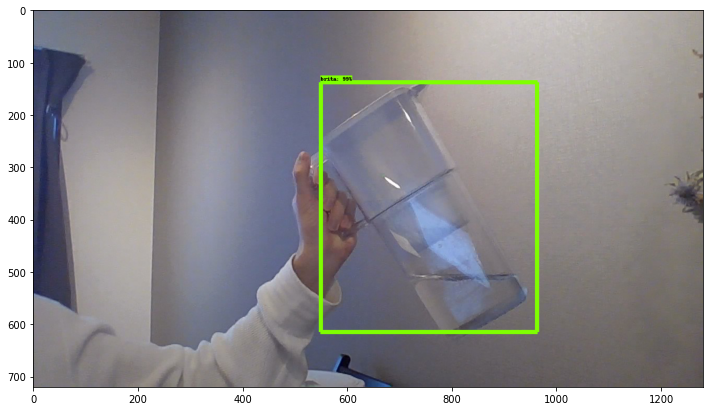

In [19]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8,
      min_score_thresh=0.4)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)